In [1069]:
#d(ady/dx)dx+bdy/dx+cy=f(x) using piecewise linear function and vpinns

In [1070]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [1071]:
def a_x(x):
    return 10**(-4)
def b_x(x):
    return 1
def c_x(x):
    return 1
def f_x(x):
    return 1

In [1072]:
def func(x):
    return np.sin(x)

In [1073]:
def midpoint_integral(a, b, f):
    return (b - a) * torch.mean(f)


In [1074]:
class Model(nn.Module):
    def __init__(self,input,output,h1):
        super().__init__()
        self.fc1=nn.Linear(input,h1)
        self.fc2=nn.Linear(h1,h1)
        self.fc4=nn.Linear(h1,h1)
        self.fc5=nn.Linear(h1,h1)
        self.fc6=nn.Linear(h1,h1)
        self.fc3=nn.Linear(h1,output)
    def forward(self,x):
        x=torch.tanh(self.fc1(x))
        x=torch.tanh(self.fc2(x))
        x=torch.tanh(self.fc4(x))
        x=torch.tanh(self.fc5(x))
        x=torch.tanh(self.fc6(x))
        x=self.fc3(x)
        return x

In [1075]:
import sympy as sp

In [1076]:
N=5
domain=[]    
for i in range(N+1):
    domain.append(i/N)

In [1077]:
x=sp.Symbol("x")
function=[]
for i in range(N-1):
    expr=[]
    for j in range(N):
        if(i==j):
            f1=(x-domain[i])/(domain[i+1]-domain[i])
            expr.append(f1)
        elif(j==(i+1)):
            f2=(domain[i+2]-x)/(domain[i+2]-domain[i+1])
            expr.append(f2)
        else:
            expr.append(sp.S(0))
    function.append(expr)
function


[[5.0*x, 2.0 - 5.0*x, 0, 0, 0],
 [0, 5.0*x - 1.0, 3.0 - 5.0*x, 0, 0],
 [0, 0, 5.0*x - 2.0, 4.0 - 5.0*x, 0],
 [0, 0, 0, 5.0*x - 3.0, 5.0 - 5.0*x]]

In [1078]:
function_deri=[]
for i in range(N-1):
    expr=[]
    for j in range(N):
            f=sp.diff(function[i][j],x)
            expr.append(f)
    function_deri.append(expr)


In [1079]:
model=Model(1,1,40)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

In [1080]:
phi = [[sp.lambdify(x, f, 'torch') for f in row] for row in function]
dphi = [[sp.lambdify(x, df, 'torch') for df in row] for row in function_deri]

In [ ]:
epochs=3000
loss_history=[]

for i in range(epochs):
    optimizer.zero_grad()
    y_0=model(torch.zeros(1,1))
    loss1=10*torch.mean((y_0-0)**2)  #boundary loss at 0
    y_1=model(torch.ones(1,1))
    loss2=10*torch.mean((y_1-0)**2)  #boundary loss at 1
    loss3=0
    for j in range(N-1):
        if (j==N-2):
            k=0.4
            x_coll1 =torch.linspace((j/N),((j+1)/N),700).reshape(-1,1).requires_grad_(True)
            fx=f_x(x_coll1)
            ax=a_x(x_coll1)
            bx=b_x(x_coll1)
            cx=c_x(x_coll1)
            ypred=model(x_coll1)
            dy_dx = torch.autograd.grad(ypred, x_coll1, torch.ones_like(ypred), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx,x_coll1, torch.ones_like(dy_dx), create_graph=True)[0]
            F1=ax*dy_dx*dphi[j][j](x_coll1)-ax*d2y_dx2*((k/N)*dphi[j][j](x_coll1))+bx*dy_dx*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))+cx*ypred*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))-fx*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))
            l1=midpoint_integral((j/N),((j+1)/N),F1)
            k=0.4
            x_coll2 =torch.linspace(((j+1)/N),((j+2)/N),1000).reshape(-1,1).requires_grad_(True)
            fx=f_x(x_coll2)
            ax=a_x(x_coll2)
            bx=b_x(x_coll2)
            cx=c_x(x_coll2)
            ypred=model(x_coll2)
            dy_dx = torch.autograd.grad(ypred, x_coll2, torch.ones_like(ypred), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx,x_coll2, torch.ones_like(dy_dx), create_graph=True)[0]
            F2=ax*dy_dx*dphi[j][j+1](x_coll2)-ax*d2y_dx2*((k/N)*dphi[j][j+1](x_coll2))+bx*dy_dx*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))+cx*ypred*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))-fx*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))
            l2=midpoint_integral(((j+1)/N),((j+2)/N),F2)
            loss3=loss3+l1**2+l2**2
        else:
            k=0.4
            x_coll1=torch.linspace((j/N),((j+1)/N),500).reshape(-1,1).requires_grad_(True)
            fx=f_x(x_coll1)
            ax=a_x(x_coll1)
            bx=b_x(x_coll1)
            cx=c_x(x_coll1)
            ypred=model(x_coll1)
            dy_dx = torch.autograd.grad(ypred, x_coll1, torch.ones_like(ypred), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx,x_coll1, torch.ones_like(dy_dx), create_graph=True)[0]
            F1=ax*dy_dx*dphi[j][j](x_coll1)-ax*d2y_dx2*((k/N)*dphi[j][j](x_coll1))+bx*dy_dx*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))+cx*ypred*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))-fx*(phi[j][j](x_coll1)+(k/N)*dphi[j][j](x_coll1))
            l1=midpoint_integral((j/N),((j+1)/N),F1)
            x_coll2=torch.linspace(((j+1)/N),((j+2)/N),500).reshape(-1,1).requires_grad_(True)
            fx=f_x(x_coll2)
            ax=a_x(x_coll2)
            bx=b_x(x_coll2)
            cx=c_x(x_coll2)
            ypred=model(x_coll2)
            dy_dx = torch.autograd.grad(ypred, x_coll2, torch.ones_like(ypred), create_graph=True)[0]
            d2y_dx2 = torch.autograd.grad(dy_dx,x_coll2, torch.ones_like(dy_dx), create_graph=True)[0]
            F2=ax*dy_dx*dphi[j][j+1](x_coll2)-ax*d2y_dx2*((k/N)*dphi[j][j+1](x_coll2))+bx*dy_dx*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))+cx*ypred*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))-fx*(phi[j][j+1](x_coll2)+(k/N)*dphi[j][j+1](x_coll2))
            l2=midpoint_integral(((j+1)/N),((j+2)/N),F2)
            loss3=loss3+l1**2+l2**2
    
        
    loss3=loss3/(N-1)
    loss=loss1+loss2+loss3
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().numpy())

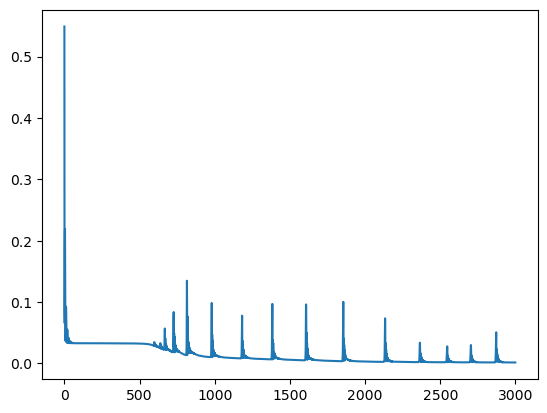

In [1082]:
plt.plot(range(epochs),loss_history)

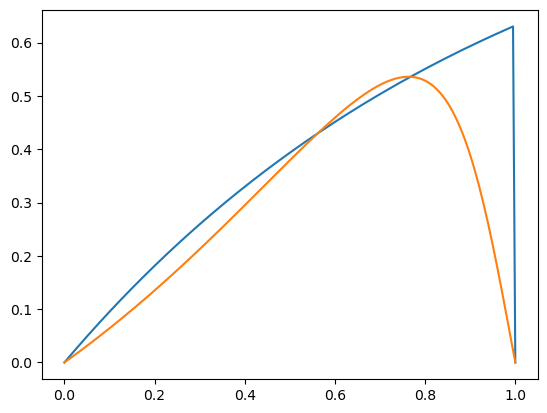

In [1083]:
with torch.no_grad():
    epsilon = 10**(-4)
    e_inv = np.exp(-1)
    e_neg10001 = np.exp(-(1/epsilon+1))
    e_neg10002 = np.exp(-(1/epsilon+2))
    A = (e_inv - 1) * e_neg10001 / (1 - e_neg10002)
    B = -1 - A
    def y_stable(x):
        return ((e_inv - 1) * np.exp(-(1/epsilon+1) * (1 - x)) / (1 - e_neg10002)+ (-1 - (e_inv - 1) * e_neg10001 / (1 - e_neg10002)) * np.exp(-x) + 1)
    x= np.linspace(0,1,200).reshape(-1, 1)  

    plt.plot(x,y_stable(x))
    x=torch.FloatTensor(x)
    ypred=model.forward(x)
    plt.plot(x,ypred)
    